In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from easymore import Easymore
import numpy as np
import rasterio
from rasterio.plot import show
from netCDF4 import Dataset, date2num
import cftime
from datetime import datetime
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
import xarray as xr

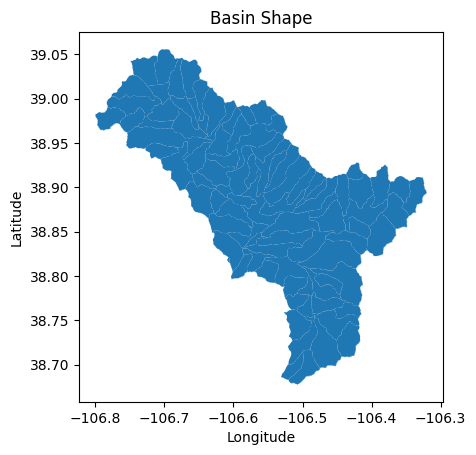

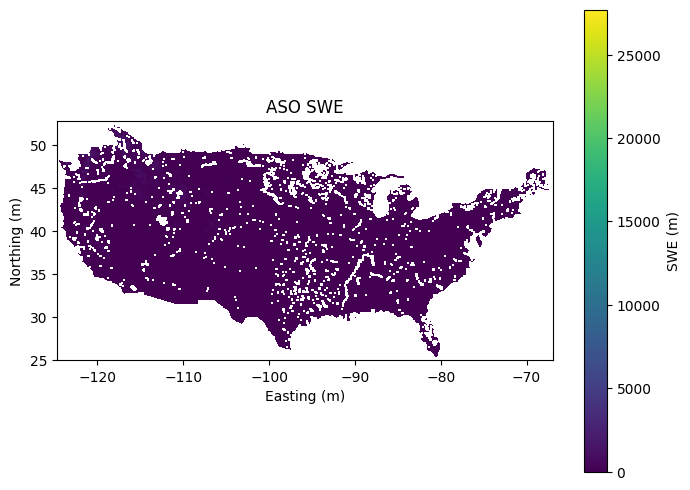

In [2]:
#Visualistation of basin shape file and SNODAS raster.


# Path to basin shapefile
basin_shp = "proj/snow_proj/basins/hydrofabrics/USCOGT_hydrofabric.shp"

# Read the basin shapefile
basin_data = gpd.read_file(basin_shp)

# Reproject the basin shapefile to EPSG:4326 (WGS84)
basin_data_wgs84 = basin_data.to_crs('EPSG:4326')

# Plot the reprojected basin shapefile
basin_data_wgs84.plot()
plt.title("Basin Shape")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



# Path to the raster file you wish to display
raster_filepath = 'scratch/data/snodas/data/SWE/2018/03_Mar/extracted/tiffs/us_swe_20180330_.tif'

# Open the raster file
with rasterio.open(raster_filepath) as src:
    # Display the raster
    fig, ax = plt.subplots(figsize=(8, 6))
    show(src, cmap='viridis', ax=ax)
    # Add colorbar
    cbar = plt.colorbar(ax.get_images()[0], ax=ax)
    cbar.set_label('SWE (m)')
    # Add axes labels
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title('ASO SWE')
    #plt.savefig('Taylor River ASO Basin 50m.png')
    plt.show()

In [3]:
#Reprojecting raster into shp file crs


# Path to the original .tif file
original_tif_path = 'scratch/data/snodas/data/SWE/2018/03_Mar/extracted/tiffs/us_swe_20180330_.tif'

# Path to save the reprojected .tif file
reprojected_tif_path = 'scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.tif'

# Define the target CRS as WGS84 (latitude/longitude)
target_crs = CRS.from_epsg(4326)

# Open the original .tif file
with rasterio.open(original_tif_path) as src:
    # Get the profile of the original raster
    src_profile = src.profile
    
    # Calculate the transform and dimensions for the reprojected raster
    transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
    
    # Update the profile with the new CRS, transform, and dimensions
    dst_profile = src.profile.copy()
    dst_profile.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'nodata': -9999  # Optional: Set nodata value
    })
    
    # Create a new raster file for the reprojected data
    with rasterio.open(reprojected_tif_path, 'w', **dst_profile) as dst:
        # Reproject the data from the original raster to the new raster
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )

print("Reprojection complete. The reprojected raster is saved as:", reprojected_tif_path)


Reprojection complete. The reprojected raster is saved as: scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.tif


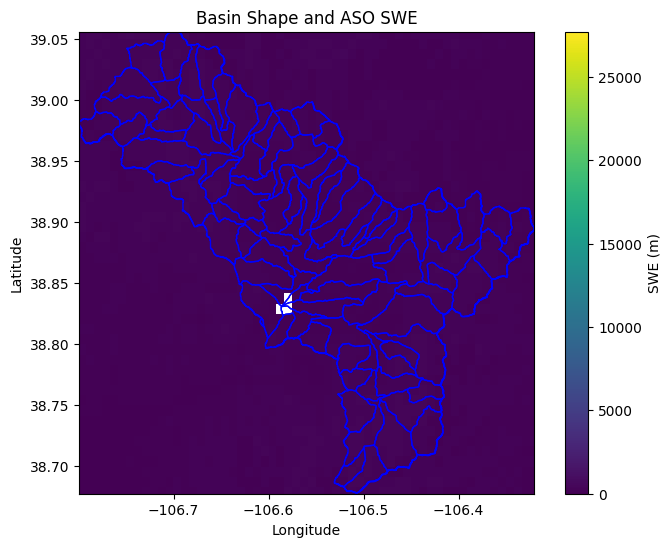

In [4]:
#Visualization of shapefile boundary over snodas tif


# Path to the original basin shapefile
basin_shp = "proj/snow_proj/basins/hydrofabrics/USCOGT_hydrofabric.shp"

# Read the basin shapefile
basin_data = gpd.read_file(basin_shp)

# Reproject the basin shapefile to EPSG:4326 (WGS84)
basin_data_wgs84 = basin_data.to_crs('EPSG:4326')

# Path to save the reprojected shapefile
reprojected_basin_shp = "proj/snow_proj/basins/hydrofabrics/USCOGT_hydrofabric_reprojected.shp"

# Save the reprojected shapefile
basin_data_wgs84.to_file(reprojected_basin_shp, driver='ESRI Shapefile')

# Verify the saved shapefile by reading it again
reprojected_basin_data = gpd.read_file(reprojected_basin_shp)

# Get the bounding box of the reprojected basin shapefile
basin_bounds = reprojected_basin_data.total_bounds

# Path to the raster file
raster_filepath = 'scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.tif'

# Open the raster file
with rasterio.open(raster_filepath) as src:
    # Create a new plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the raster first
    show(src, cmap='viridis', ax=ax)
    cbar = plt.colorbar(ax.get_images()[0], ax=ax)
    cbar.set_label('SWE (m)')
    
    # Plot the reprojected basin shapefile on top
    reprojected_basin_data.plot(ax=ax, color='none', edgecolor='blue')  # Plot the outline of the basin
    
    ax.set_title("Basin Shape and ASO SWE")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Set the extent of the plot to match the bounding box of the reprojected basin shapefile
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

plt.show()


In [5]:
#SNodas raster variables

# Path to the raster file
raster_filepath = 'scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.tif'

# Open the raster file
with rasterio.open(raster_filepath) as src:
    # Print the raster metadata
    print("Raster Metadata:")
    print(src.profile)
    print("\n")
    
    # Print the raster dimensions
    print("Raster Dimensions:")
    print(src.width, "x", src.height)
    print("\n")
    
    # Print the raster coordinate reference system (CRS)
    print("Raster CRS:")
    print(src.crs)
    print("\n")
    
    # Print the raster transform (geotransform)
    print("Raster Transform:")
    print(src.transform)
    print("\n")
    
    # Read the raster data into a numpy array
    raster_data = src.read(1)  # Assuming it's a single-band raster
    
    # Print information about the raster values
    print("Raster Data:")
    print("Shape:", raster_data.shape)
    print("Data Type:", raster_data.dtype)
    print("No Data Value:", src.nodatavals)
    print("\n")
    
    # Calculate summary statistics
    print("Summary Statistics:")
    print("Minimum:", np.nanmin(raster_data))
    print("Maximum:", np.nanmax(raster_data))
    print("Mean:", np.nanmean(raster_data))
    print("Median:", np.nanmedian(raster_data))
    print("Standard Deviation:", np.nanstd(raster_data))
    print("\n")


Raster Metadata:
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 6935, 'height': 3351, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333333002, 0.0, -124.73374999999866,
       0.0, -0.008333333333333002, 52.87458333333227), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


Raster Dimensions:
6935 x 3351


Raster CRS:
EPSG:4326


Raster Transform:
| 0.01, 0.00,-124.73|
| 0.00,-0.01, 52.87|
| 0.00, 0.00, 1.00|


Raster Data:
Shape: (3351, 6935)
Data Type: int16
No Data Value: (-9999.0,)


Summary Statistics:
Minimum: -9999
Maximum: 27709
Mean: -4819.9553072967055
Median: 0.0
Standard Deviation: 5017.780827225578




In [6]:
#Creating time string


# File name
file_name = 'scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.tif'

# Extract date from file name
date_str = file_name.split('_')[-2]

# Convert date string to datetime object
date = datetime.strptime(date_str, '%Y%m%d')

# Format date as required for netCDF time variable (e.g., days since a specific date)
reference_date = datetime(1900, 1, 1)
time_since_reference = (date - reference_date).days

# Print the date and time since reference date
print("Date:", date)
print("Time since reference date (days):", time_since_reference)


Date: 2018-03-30 00:00:00
Time since reference date (days): 43187


In [7]:
#Appending time string to the raster as a time variable and converting to netcdf

# File name
file_name = 'scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.tif'

# Extract date from file name
date_str = file_name.split('_')[4]
date = datetime.strptime(date_str, '%Y%m%d')

# Convert date to cftime datetime object
cftime_date = cftime.datetime(date.year, date.month, date.day, calendar='gregorian')

# Open the raster file
with rasterio.open(file_name) as src:
    # Read the raster data
    data = src.read(1)
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

    # Generate coordinates
    cols, rows = np.meshgrid(np.arange(src.width), np.arange(src.height))
    lon, lat = rasterio.transform.xy(transform, rows, cols)
    lon = np.array(lon)
    lat = np.array(lat)

# Debugging: Print shapes of lon and lat arrays
print(f'lon shape: {lon.shape}, lat shape: {lat.shape}')

# Define the netCDF file
nc_file = 'scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.nc'

# Create a netCDF dataset
with Dataset(nc_file, 'w', format='NETCDF4') as nc:
    # Create dimensions
    lat_dim = nc.createDimension('lat', lat.shape[0])
    lon_dim = nc.createDimension('lon', lon.shape[1])
    time_dim = nc.createDimension('time', None)  # Unlimited time dimension

    # Create variables
    lat_var = nc.createVariable('lat', 'f4', ('lat',))
    lon_var = nc.createVariable('lon', 'f4', ('lon',))
    time_var = nc.createVariable('time', 'f4', ('time',))
    swe_var = nc.createVariable('SWE', 'f4', ('time', 'lat', 'lon',), fill_value=nodata)
    
    # Set variable attributes
    lat_var.units = 'degrees_north'
    lon_var.units = 'degrees_east'
    time_var.units = 'days since 1900-01-01 00:00:00'
    time_var.calendar = 'gregorian'
    time_var.long_name = 'time'
    swe_var.units = 'm'
    swe_var.long_name = 'Snow Water Equivalent'
    
    # Write data to variables
    lat_var[:] = lat[:, 0]  # Extract latitude values (all rows of the first column)
    lon_var[:] = lon[0, :]  # Extract longitude values (all columns of the first row)
    time_var[0] = date2num(cftime_date, units=time_var.units, calendar=time_var.calendar)
    swe_var[0, :, :] = data

print(f'NetCDF file created: {nc_file}')


lon shape: (3351, 6935), lat shape: (3351, 6935)
NetCDF file created: scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.nc


In [8]:
#netcdf variables

# Path to the NetCDF file
raster_filepath = 'scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.nc'

# Open the NetCDF file
nc_file = Dataset(raster_filepath, 'r')

# Print variable names and their attributes
for var_name in nc_file.variables:
    print("Variable:", var_name)
    print("Attributes:")
    for attr_name in nc_file.variables[var_name].ncattrs():
        print(f"    {attr_name}: {nc_file.variables[var_name].getncattr(attr_name)}")

# Close the NetCDF file
nc_file.close()


Variable: lat
Attributes:
    units: degrees_north
Variable: lon
Attributes:
    units: degrees_east
Variable: time
Attributes:
    units: days since 1900-01-01 00:00:00
    calendar: gregorian
    long_name: time
Variable: SWE
Attributes:
    _FillValue: -9999.0
    units: m
    long_name: Snow Water Equivalent


In [9]:
#Visualize netcdf and shapefile variables

# Path to the shapefile and NetCDF file
shapefile_path = "proj/snow_proj/basins/hydrofabrics/USCOGT_hydrofabric_reprojected.shp"
netcdf_path = "scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_reproj.nc"

# Read the shapefile
shapefile = gpd.read_file(shapefile_path)

# Read the NetCDF file
nc_data = xr.open_dataset(netcdf_path)

# Display basic information about the shapefile and NetCDF file
print("Shapefile Info:")
print(shapefile.info())

print("\nNetCDF Info:")
print(nc_data)


Shapefile Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   divide_id   140 non-null    object  
 1   toid        140 non-null    object  
 2   type        140 non-null    object  
 3   ds_id       140 non-null    float64 
 4   areasqkm    140 non-null    float64 
 5   id          140 non-null    object  
 6   lengthkm    140 non-null    float64 
 7   tot_draina  140 non-null    float64 
 8   has_flowli  140 non-null    int64   
 9   geom_Lengt  140 non-null    float64 
 10  geom_Area   140 non-null    float64 
 11  geometry    140 non-null    geometry
dtypes: float64(6), geometry(1), int64(1), object(4)
memory usage: 13.2+ KB
None

NetCDF Info:
<xarray.Dataset> Size: 93MB
Dimensions:  (lat: 3351, lon: 6935, time: 1)
Coordinates:
  * lat      (lat) float32 13kB 52.87 52.86 52.85 52.85 ... 24.97 24.96 24.95
  * lon      (lon) float

In [10]:
#Clip netcdf to the extent of the shapefile

from rasterio.mask import mask

# Get the bounding box of the shapefile
bbox = shapefile.total_bounds

# Define the spatial extent for clipping
min_lon, min_lat, max_lon, max_lat = bbox

# Define the bounding box for clipping
bbox = [min_lon, min_lat, max_lon, max_lat]

# Clip the NetCDF data to the extent of the shapefile
clipped_data = nc_data.sel(lon=slice(min_lon, max_lon), lat=slice(max_lat, min_lat))

# Display the clipped NetCDF data
print(clipped_data)

# Save the clipped NetCDF data to a new file
clipped_data.to_netcdf("scratch/data/snodas/data/easymore_reproj_SNODAS/us_swe_20180330_clipped.nc")


<xarray.Dataset> Size: 11kB
Dimensions:  (lat: 46, lon: 58, time: 1)
Coordinates:
  * lat      (lat) float32 184B 39.05 39.05 39.04 39.03 ... 38.7 38.69 38.68
  * lon      (lon) float32 232B -106.8 -106.8 -106.8 ... -106.3 -106.3 -106.3
  * time     (time) datetime64[ns] 8B 2018-03-30
Data variables:
    SWE      (time, lat, lon) float32 11kB ...
